# access thredds manual

getting different regions of current data manually instead of using the auto-generated regions.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import xarray as xr

In [3]:
dataset_url_6kmhourly = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/6km/hourly/RTV/HFRADAR_US_West_Coast_6km_Resolution_Hourly_RTV_best.ncd"
dataset_url_2kmhourly = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/2km/hourly/RTV/HFRADAR_US_West_Coast_2km_Resolution_Hourly_RTV_best.ncd"
dataset_url_1kmhourly = "http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USWC/1km/hourly/RTV/HFRADAR_US_West_Coast_1km_Resolution_Hourly_RTV_best.ncd"

DATA_6KM = 6
DATA_2KM = 2
DATA_1KM = 1

filename_dict = {
    DATA_6KM: "west_coast_6km_hourly",
    DATA_2KM: "west_coast_2km_hourly",
    DATA_1KM: "west_coast_1km_hourly"
}

def get_region(data):
    time_range = data[2]
    if isinstance(time_range[0], str):
        time_range = (np.datetime64(time_range[0]), np.datetime64(time_range[1]))
    lat_range = data[3]
    lon_range = data[4]
    return dict(
        name = data[0],
        category = data[1],
        time = time_range,
        lat = lat_range,
        lon = lon_range,
        domain = {
            "S": lat_range[0],
            "N": lat_range[1],
            "W": lon_range[0],
            "E": lon_range[1],
        }
    )

In [6]:
num_chunks = 50

thredds_data = {
    DATA_6KM: xr.open_dataset(dataset_url_6kmhourly, chunks={"time": num_chunks}),
    DATA_2KM: xr.open_dataset(dataset_url_2kmhourly, chunks={"time": num_chunks}),
    DATA_1KM: xr.open_dataset(dataset_url_1kmhourly, chunks={"time": num_chunks})
}

In [7]:
region_data = [
    ("tijuana_river", DATA_2KM, ("2020-06-16T21", "2020-06-23T21"), (32.528, 32.71), (-117.29, -117.11)),
    ("tijuana_river", DATA_1KM, ("2020-06-16T21", "2020-06-23T21"), (32.528, 32.71), (-117.29, -117.11))
]

In [8]:
regions = []
for rd in region_data:
    new_reg = get_region(rd)
    new_reg["dataset"] = thredds_data[new_reg["category"]].sel(
        time=slice(new_reg["time"][0], new_reg["time"][1]),
        lat=slice(new_reg["lat"][0], new_reg["lat"][1]),
        lon=slice(new_reg["lon"][0], new_reg["lon"][1]),
    )
    regions.append(new_reg)
    print(f"region {new_reg['name']} data megabytes: {new_reg['dataset'].nbytes / 1024 / 1024}")

region tijuana_river data megabytes: 0.4101133346557617
region tijuana_river data megabytes: 1.5383787155151367


In [9]:
for r in regions:
    save_dir = filename_dict[r["category"]] + "_netcdfs/"
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
        print(f"created new directory {save_dir}")
    filename = filename_dict[r['category']] + f"_region_{r['name']}.nc"
    # save file
    r["dataset"].to_netcdf(save_dir + filename)
    print(f"saved to {save_dir + filename}")
print("done")

saved to west_coast_2km_hourly_netcdfs/west_coast_2km_hourly_region_tijuana_river.nc
created new directory west_coast_1km_hourly_netcdfs/
saved to west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river.nc
done


## fieldset testing

In [10]:
from parcels import FieldSet

/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jerry/miniconda3/envs/py3_parcels/lib/python3.6/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


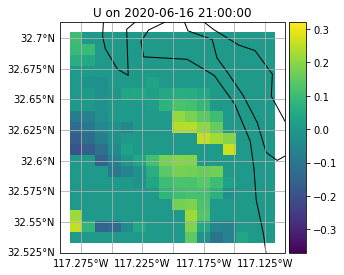

In [12]:
netcdf_filename = "west_coast_1km_hourly_netcdfs/west_coast_1km_hourly_region_tijuana_river.nc"
ds = xr.open_dataset(netcdf_filename)
fs = FieldSet.from_xarray_dataset(ds, dict(U="u",V="v"), dict(lat="lat",lon="lon",time="time"))
ds.close()
fs.U.show()